In [1]:
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
from statistics import mode
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Activation, Flatten, MaxPooling2D
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [2]:
# SET50 (unrealize)
SET50 = ['ADVANC', 'AOT', 'BANPU', 'BBL', 'BCP', 'BDMS',
        'BEM', 'BH', 'BJC', 'BTS', 'CENTEL', 'CPALL', 
         'CPF', 'CPN', 'DTAC', 'EGCO', 'GLOBAL', 'HMPRO', 
         'INTUCH', 'IRPC', 'KBANK', 'KCE', 'KKP', 'KTB', 'LH', 'MINT', 'PTT',
        'PTTEP', 'ROBINS', 'SCB', 'SCC', 
        'TCAP', 'TISCO', 'TMB', 'TOP', 'TRUE', 'TU']

# remove (low data) : TPIPP WHA SPRC SAWAD PSH MTLS IVL GPSC EA CBG BPP BEAUTY PTTGC

In [3]:
def load_stock_data(symbol, year_start, year_end):
    stock_data = []
    with open('./SET50/' + symbol + '.BK.csv', 'r') as csv_file:
        file_data = csv.reader(csv_file, delimiter=',')
        file_data = list(file_data)[1:]
        temp_value = 0
        for row in file_data:
            if row[2] is '':
                continue
            elif int(row[0][0:4]) >= year_start and int(row[0][0:4]) <= year_end:
                temp = (float(row[1]) + float(row[4]))/2.0
                if temp_value != 0:
                    unrealize = (temp - temp_value) / temp_value
                else:
                    unrealize = 0
                unrealize = ["{0:.4f}".format(unrealize)]
                stock_data.append(unrealize)
                temp_value = temp
                
    return stock_data

def mean_square_error(actual, predict):
    length = len(actual)
    sums_error = 0.0
    for i, j in zip(actual, predict):
        sums_error += (i - j)**2
    
    return sums_error / length

def findNewXTest(x_test, predict):
    for (index, element) in enumerate(x_test[0]):
        for i in range(len(element)):
            if i == 0:
                continue
            elif i < 29:
                element[i - 1] = element[i]
            else:
                element[i - 1] = element[i]
                element[i] = "{0:.4f}".format(predict[index])
    return x_test

In [4]:
stock_datas = [ load_stock_data(x, 2007, 2017) for x in SET50 ]

min_count = len(stock_datas[0])

for index, element in enumerate(stock_datas):
    if len(element) < min_count:
        min_count = len(element)

min_count

2043

In [95]:
def create_model(conv_count, fully_count):
    i = 0
    model = Sequential()
    
    while(i <= conv_count):
        if i == 0:
            model.add(Conv2D(256, (5, 1), input_shape=(len(stock_datas), 30, 1), padding='same'))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size = (2, 1)))
        else:
            model.add(Conv2D(128, (3, 1)))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size = (2, 1)))
        i += 1
        
    i = 0
    model.add(Dropout(0.2))
    model.add(Flatten())
    
    while(i <= fully_count):
        if i == fully_count:
            model.add(Dropout(0.2))
            model.add(Dense(len(stock_datas)))
        else:
            model.add(Dense(256))  
            model.add(Activation('relu'))
        i += 1
    
    return model

In [100]:
size = 3
models = [create_model(2,_) for _ in range(size)]
# (3,1) (3,2) (3,3) 
# first for conv, second for fully connected
        

In [101]:
lr = 0.7
decay = 1e-6

In [102]:
optimizer = SGD(lr=lr, decay=decay)
for model in models:
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

In [76]:
rounds = min_count - 30
train_index = int(rounds * 0.85)
validate_index = train_index + int(rounds * 0.1)

In [77]:
data = []
count = 0
index = 0
while index < rounds:
    temp = [i[index : index + 30] for i in stock_datas]
    data.append(temp)
    index += 1
    
x = np.asarray(data)
x_train = x[0: train_index].astype('float32')
x_validate = x[train_index: validate_index].astype('float32')
x_test = x[validate_index: validate_index + 1].astype('float32')

print(x_train.shape, x_validate.shape, x_test.shape)

(1711, 37, 30, 1) (201, 37, 30, 1) (1, 37, 30, 1)


In [78]:
target = []
index = 0
while index < rounds:
    temp = [stock_datas[i][index + 30][0] for i in range(len(stock_datas))]
    target.append(temp)
    index += 1
    
y = np.asarray(target)
y_train = y[0: train_index].astype('float32')
y_validate = y[train_index: validate_index].astype('float32')
y_test = y[validate_index: rounds].astype('float32')

print(y_train.shape, y_validate.shape, y_test.shape)

(1711, 37) (201, 37) (101, 37)


In [103]:
epochs = 100

for model in models:
    print(model)
    model.fit(x_train, y_train, validation_data = (x_validate, y_validate), epochs = epochs, shuffle = True, batch_size = 100, verbose= 1)
    

Train on 1711 samples, validate on 201 samples
Epoch 1/100
1711/1711 [==============================] - 8s 5ms/step - loss: 7.8248e-04 - mean_squared_error: 7.8248e-04 - val_loss: 1.6319e-04 - val_mean_squared_error: 1.6319e-04
Epoch 2/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.7917e-04 - mean_squared_error: 7.7917e-04 - val_loss: 1.6339e-04 - val_mean_squared_error: 1.6339e-04
Epoch 3/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.8057e-04 - mean_squared_error: 7.8057e-04 - val_loss: 1.6354e-04 - val_mean_squared_error: 1.6354e-04
Epoch 4/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.7867e-04 - mean_squared_error: 7.7867e-04 - val_loss: 1.6357e-04 - val_mean_squared_error: 1.6357e-04
Epoch 5/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.7844e-04 - mean_squared_error: 7.7844e-04 - val_loss: 1.6383e-04 - val_mean_squared_error: 1.6383e-04
Epoch 6/100
1711/1711 [=========================

1711/1711 [==============================] - 4s 2ms/step - loss: 7.6642e-04 - mean_squared_error: 7.6642e-04 - val_loss: 1.6306e-04 - val_mean_squared_error: 1.6306e-04
Epoch 46/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6589e-04 - mean_squared_error: 7.6589e-04 - val_loss: 1.6356e-04 - val_mean_squared_error: 1.6356e-04
Epoch 47/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6524e-04 - mean_squared_error: 7.6524e-04 - val_loss: 1.6286e-04 - val_mean_squared_error: 1.6286e-04
Epoch 48/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6456e-04 - mean_squared_error: 7.6456e-04 - val_loss: 1.6668e-04 - val_mean_squared_error: 1.6668e-04
Epoch 49/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6703e-04 - mean_squared_error: 7.6703e-04 - val_loss: 1.6424e-04 - val_mean_squared_error: 1.6424e-04
Epoch 50/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6522e-04 - mean_squared

1711/1711 [==============================] - 4s 2ms/step - loss: 7.5877e-04 - mean_squared_error: 7.5877e-04 - val_loss: 1.6288e-04 - val_mean_squared_error: 1.6288e-04
Epoch 91/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6046e-04 - mean_squared_error: 7.6046e-04 - val_loss: 1.6304e-04 - val_mean_squared_error: 1.6304e-04
Epoch 92/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5916e-04 - mean_squared_error: 7.5916e-04 - val_loss: 1.6340e-04 - val_mean_squared_error: 1.6340e-04
Epoch 93/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5856e-04 - mean_squared_error: 7.5856e-04 - val_loss: 1.6733e-04 - val_mean_squared_error: 1.6733e-04
Epoch 94/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5957e-04 - mean_squared_error: 7.5957e-04 - val_loss: 1.6484e-04 - val_mean_squared_error: 1.6484e-04
Epoch 95/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5889e-04 - mean_squared

1711/1711 [==============================] - 4s 2ms/step - loss: 7.6726e-04 - mean_squared_error: 7.6726e-04 - val_loss: 1.6324e-04 - val_mean_squared_error: 1.6324e-04
Epoch 35/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6512e-04 - mean_squared_error: 7.6512e-04 - val_loss: 1.6332e-04 - val_mean_squared_error: 1.6332e-04
Epoch 36/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6568e-04 - mean_squared_error: 7.6568e-04 - val_loss: 1.6272e-04 - val_mean_squared_error: 1.6272e-04
Epoch 37/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6599e-04 - mean_squared_error: 7.6599e-04 - val_loss: 1.6289e-04 - val_mean_squared_error: 1.6289e-04
Epoch 38/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6557e-04 - mean_squared_error: 7.6557e-04 - val_loss: 1.6350e-04 - val_mean_squared_error: 1.6350e-04
Epoch 39/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6500e-04 - mean_squared

1711/1711 [==============================] - 4s 2ms/step - loss: 7.6220e-04 - mean_squared_error: 7.6220e-04 - val_loss: 1.6272e-04 - val_mean_squared_error: 1.6272e-04
Epoch 80/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6101e-04 - mean_squared_error: 7.6101e-04 - val_loss: 1.6272e-04 - val_mean_squared_error: 1.6272e-04
Epoch 81/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6271e-04 - mean_squared_error: 7.6271e-04 - val_loss: 1.6283e-04 - val_mean_squared_error: 1.6283e-04
Epoch 82/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6215e-04 - mean_squared_error: 7.6215e-04 - val_loss: 1.6338e-04 - val_mean_squared_error: 1.6338e-04
Epoch 83/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6152e-04 - mean_squared_error: 7.6152e-04 - val_loss: 1.6395e-04 - val_mean_squared_error: 1.6395e-04
Epoch 84/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6095e-04 - mean_squared

1711/1711 [==============================] - 4s 2ms/step - loss: 7.6682e-04 - mean_squared_error: 7.6682e-04 - val_loss: 1.6316e-04 - val_mean_squared_error: 1.6316e-04
Epoch 24/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6646e-04 - mean_squared_error: 7.6646e-04 - val_loss: 1.6329e-04 - val_mean_squared_error: 1.6329e-04
Epoch 25/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6703e-04 - mean_squared_error: 7.6703e-04 - val_loss: 1.6327e-04 - val_mean_squared_error: 1.6327e-04
Epoch 26/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6717e-04 - mean_squared_error: 7.6717e-04 - val_loss: 1.6327e-04 - val_mean_squared_error: 1.6327e-04
Epoch 27/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6719e-04 - mean_squared_error: 7.6719e-04 - val_loss: 1.6341e-04 - val_mean_squared_error: 1.6341e-04
Epoch 28/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6591e-04 - mean_squared

1711/1711 [==============================] - 4s 2ms/step - loss: 7.6235e-04 - mean_squared_error: 7.6235e-04 - val_loss: 1.6285e-04 - val_mean_squared_error: 1.6285e-04
Epoch 69/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6239e-04 - mean_squared_error: 7.6239e-04 - val_loss: 1.6317e-04 - val_mean_squared_error: 1.6317e-04
Epoch 70/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6243e-04 - mean_squared_error: 7.6243e-04 - val_loss: 1.6326e-04 - val_mean_squared_error: 1.6326e-04
Epoch 71/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6258e-04 - mean_squared_error: 7.6258e-04 - val_loss: 1.6347e-04 - val_mean_squared_error: 1.6347e-04
Epoch 72/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6180e-04 - mean_squared_error: 7.6180e-04 - val_loss: 1.6362e-04 - val_mean_squared_error: 1.6362e-04
Epoch 73/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6244e-04 - mean_squared

In [104]:
errors = [[] for i in range(3)]
predicts = [[] for i in range(3)]
for i in range(3):
    test_data = x_test.copy()
    for (index, element) in enumerate(y_test):
        predict = models[i].predict(test_data, verbose = 0)
        predicts[i].append(predict[0])
        errors[i].append(mean_square_error(element, predict[0]))
        test_data = findNewXTest(test_data, predict[0])

In [105]:
predicts = [np.asarray(predict).astype('float32') for predict in predicts]

In [106]:
def plot_graph(array1, array2, array3, array4):
    plt.figure(figsize=(20,10))
    x_axis = [i for i in range(len(array1))]
    plt.plot(x_axis, array1, 'r')
    plt.plot(x_axis, array2, 'b')
    plt.plot(x_axis, array3, 'g')
    plt.plot(x_axis, array4, 'y')

    plt.show()
    
def get_data_from_nparray(nparray, index):
    return_data = [i[index] for i in nparray]
    return return_data

ADVANC


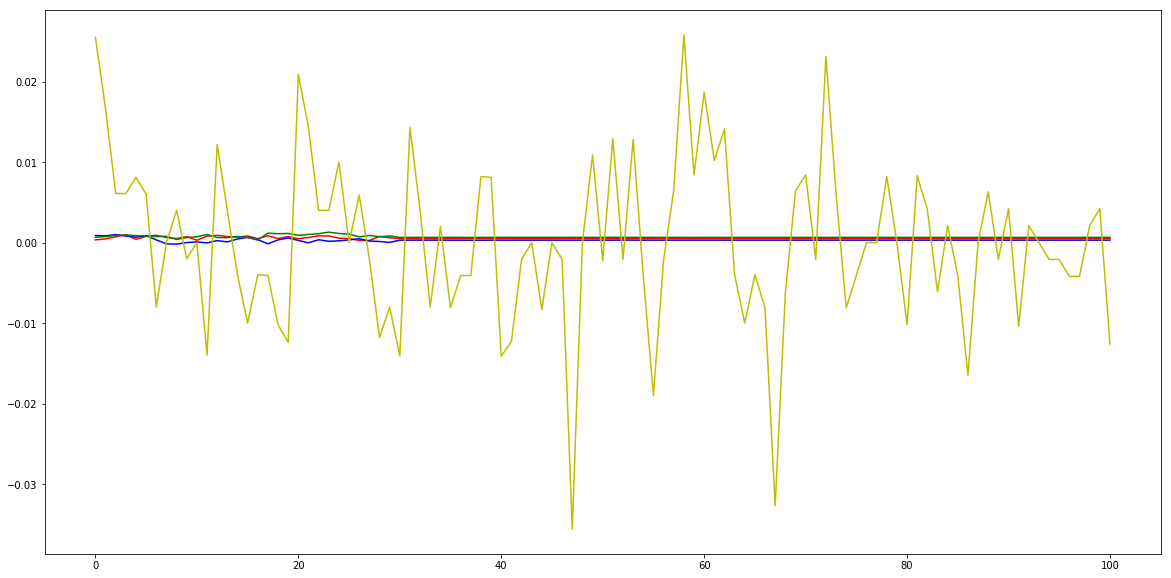

AOT


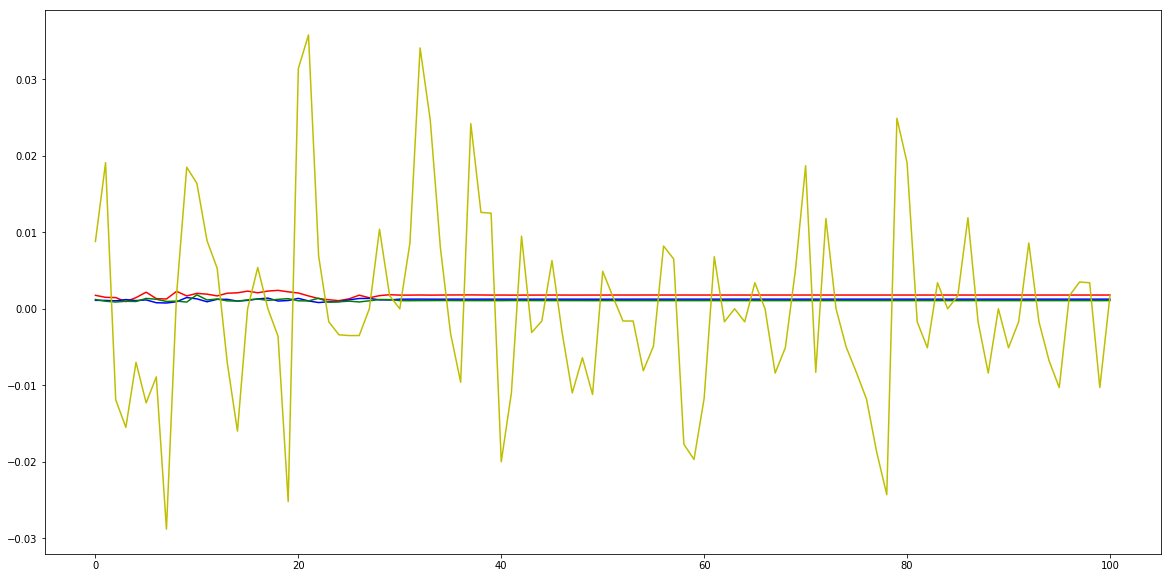

BANPU


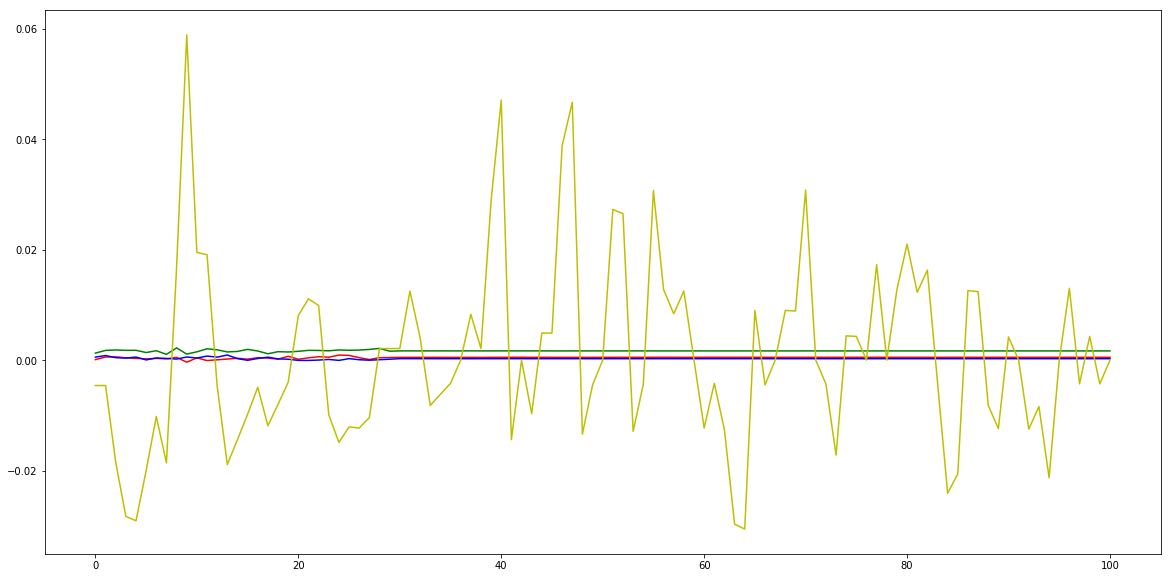

BBL


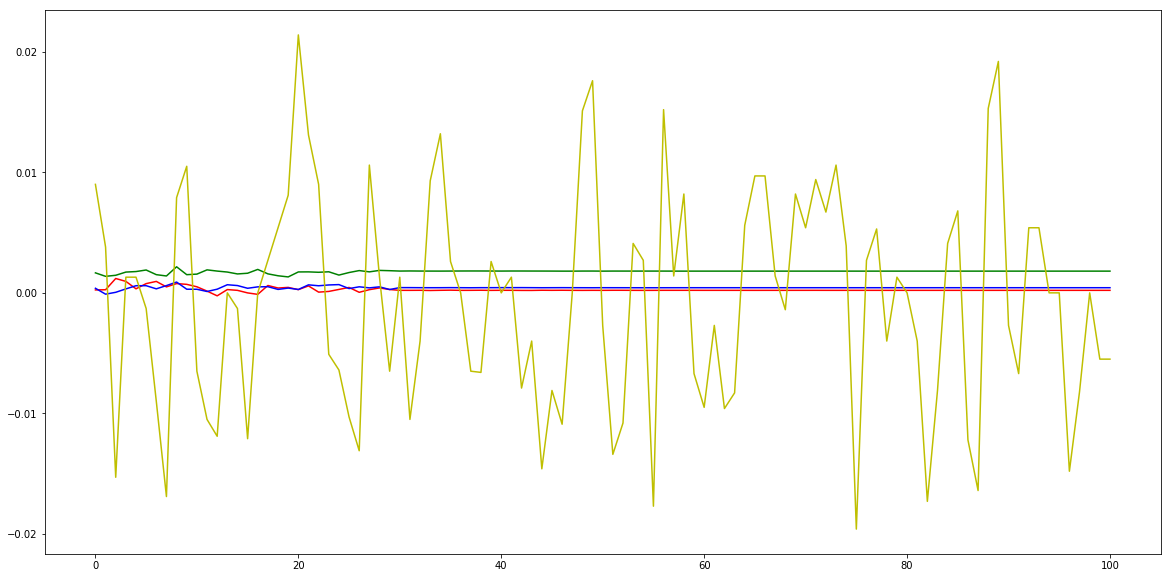

BCP


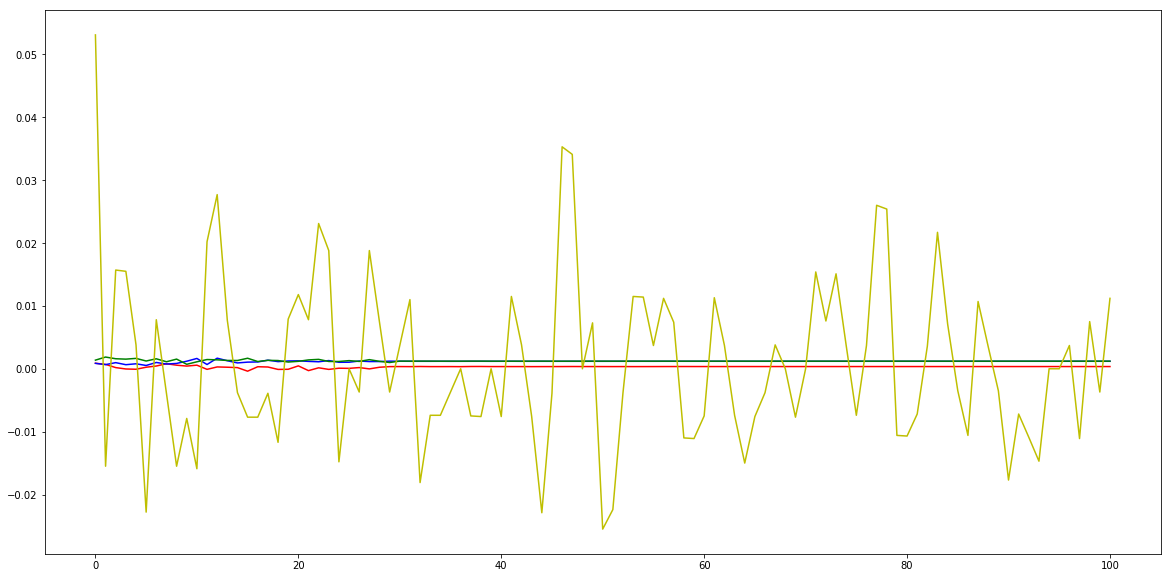

BDMS


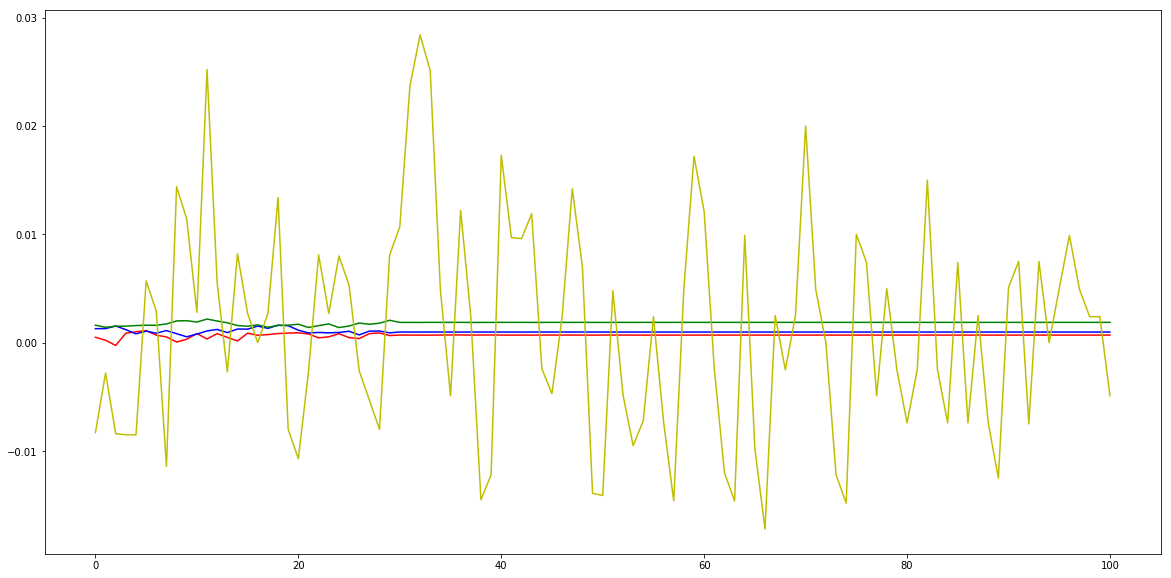

BEM


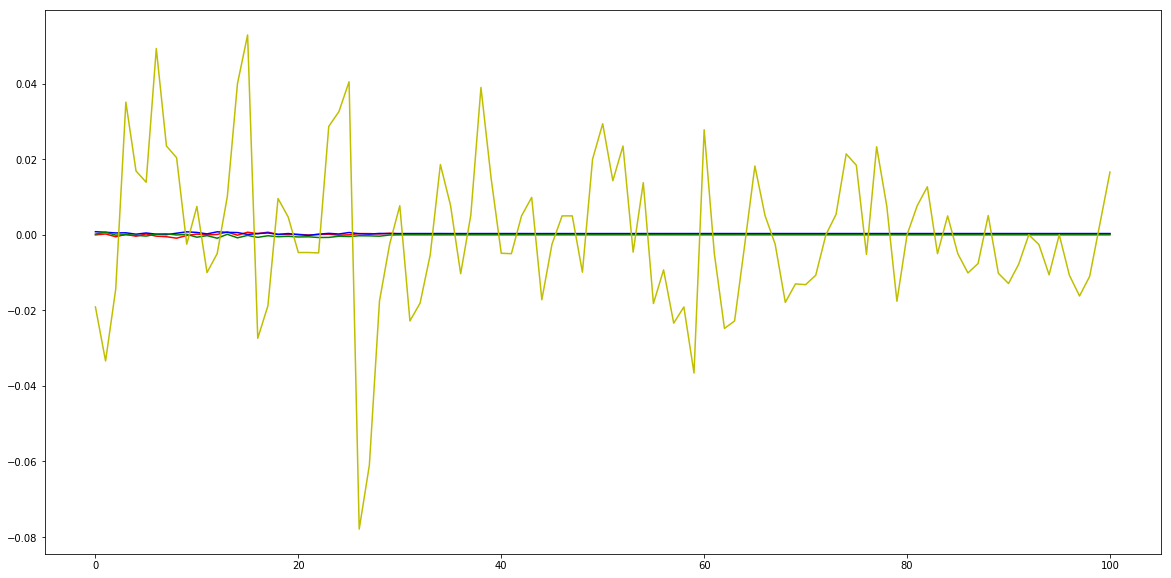

BH


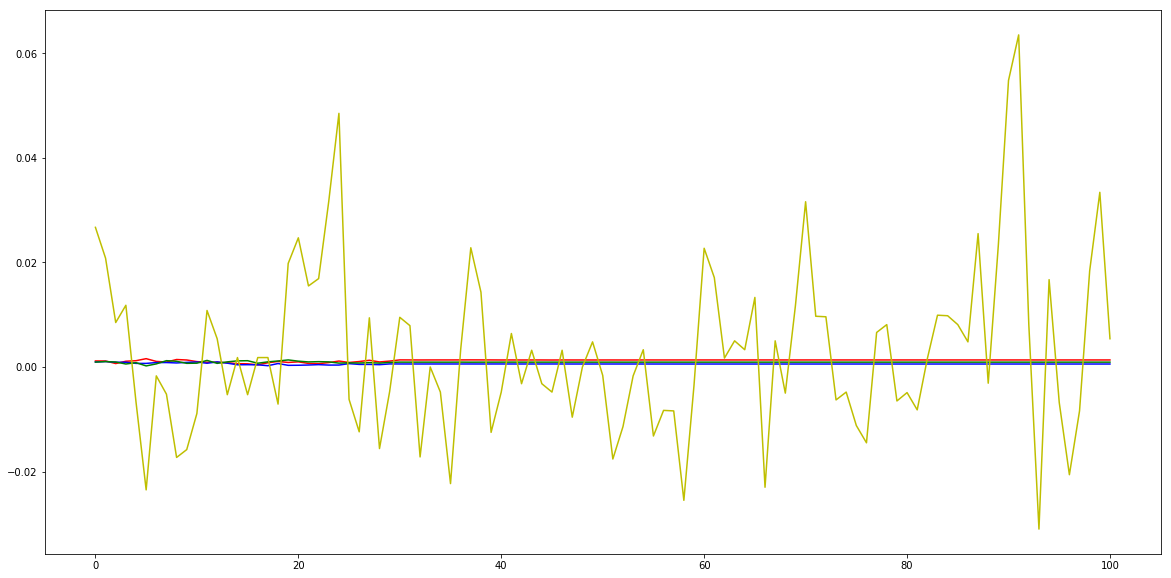

BJC


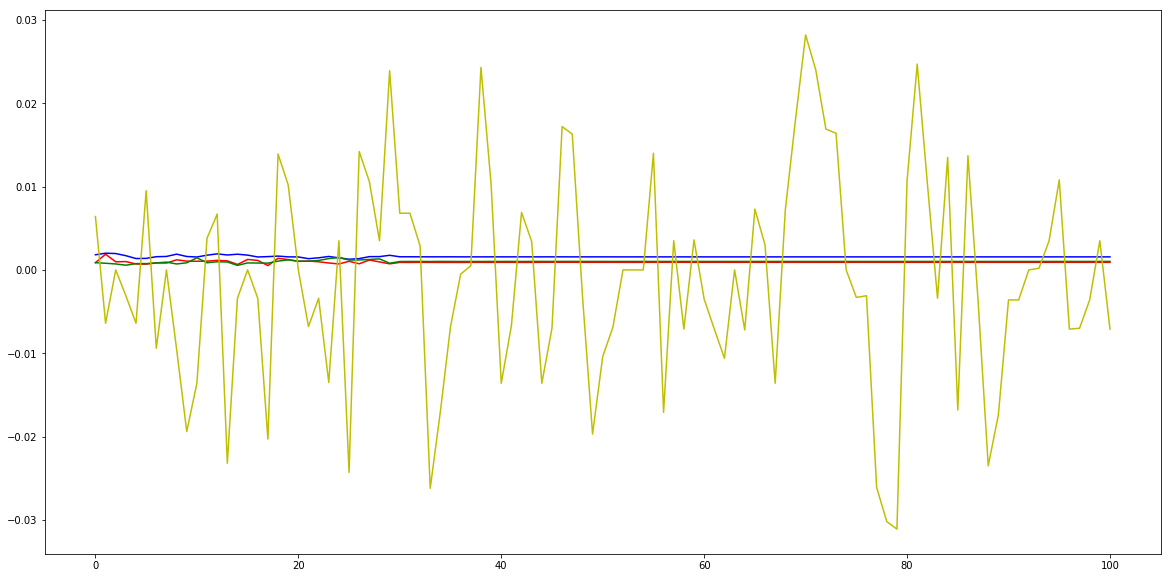

BTS


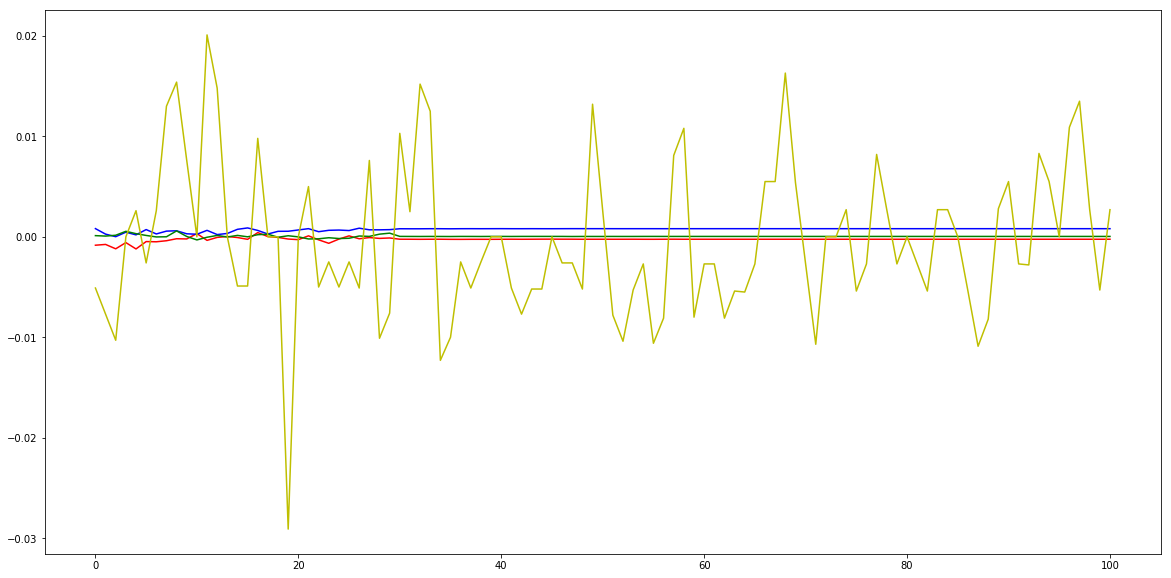

CENTEL


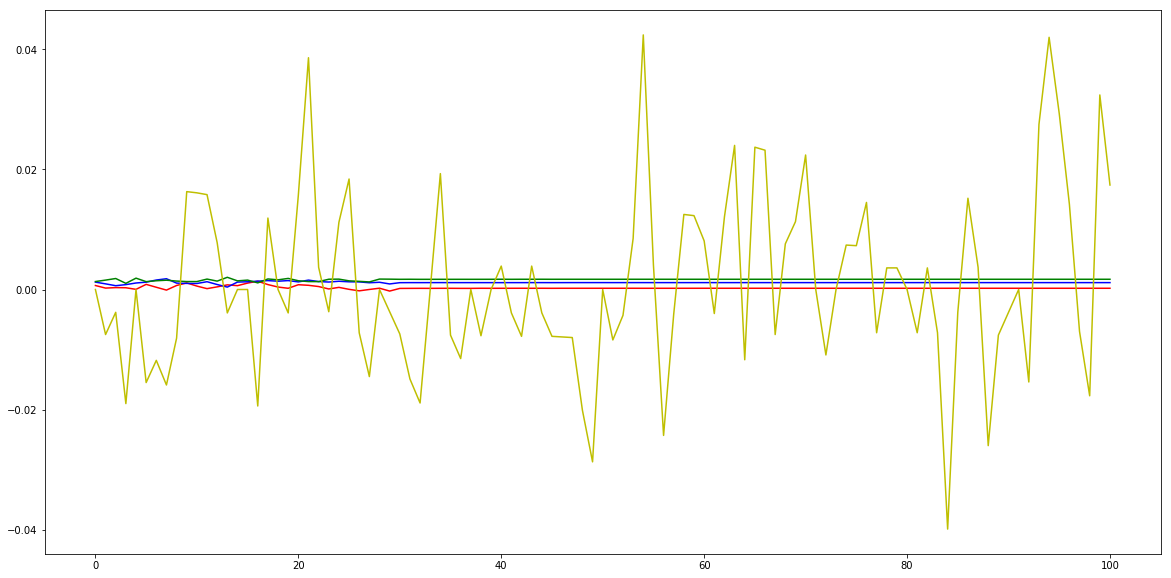

CPALL


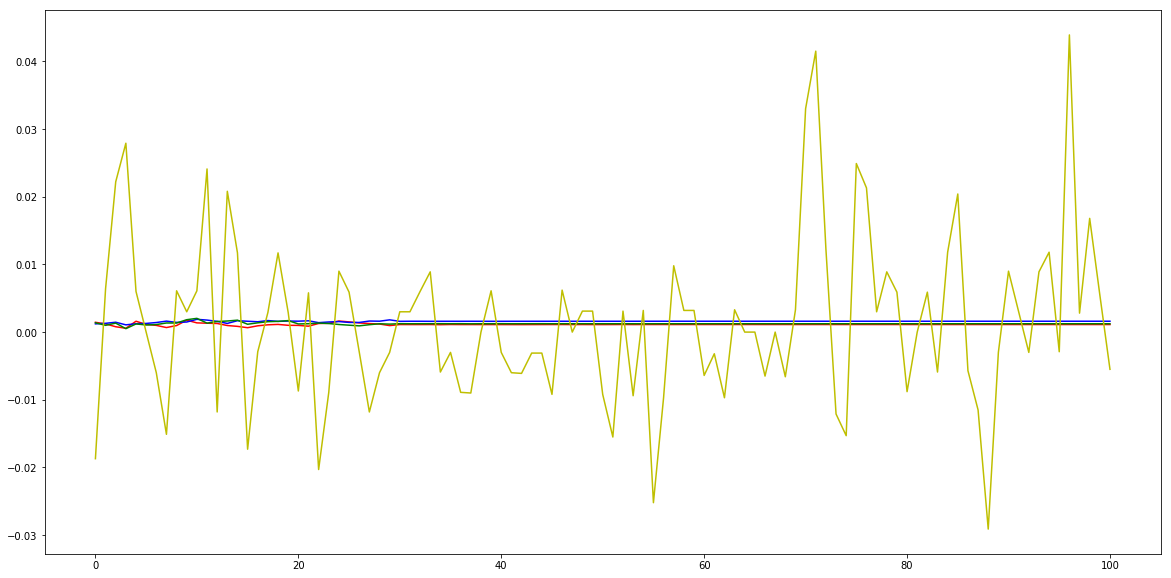

CPF


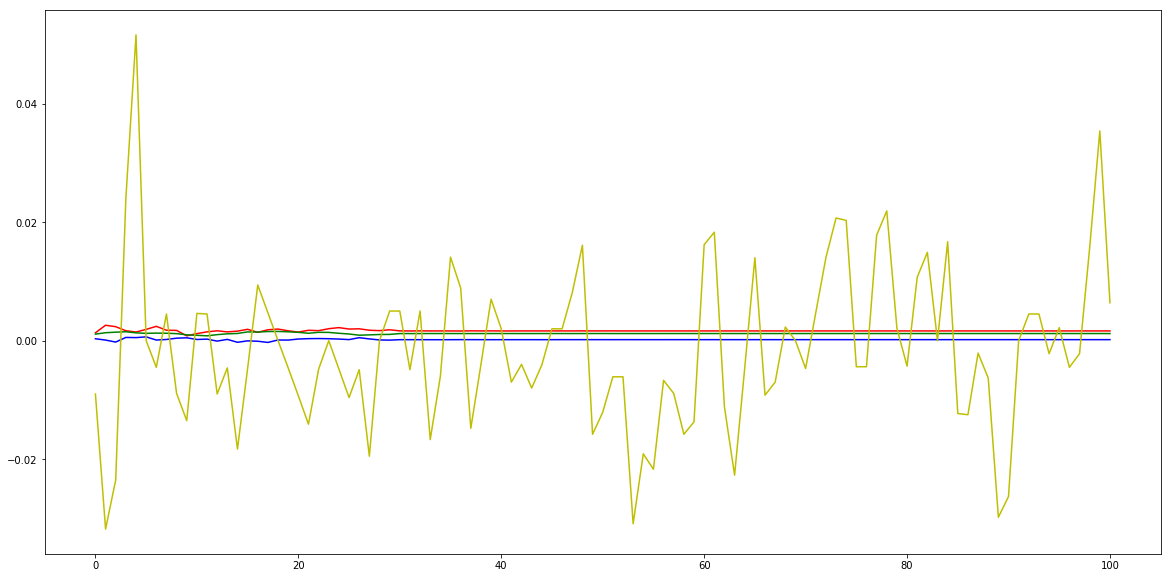

CPN


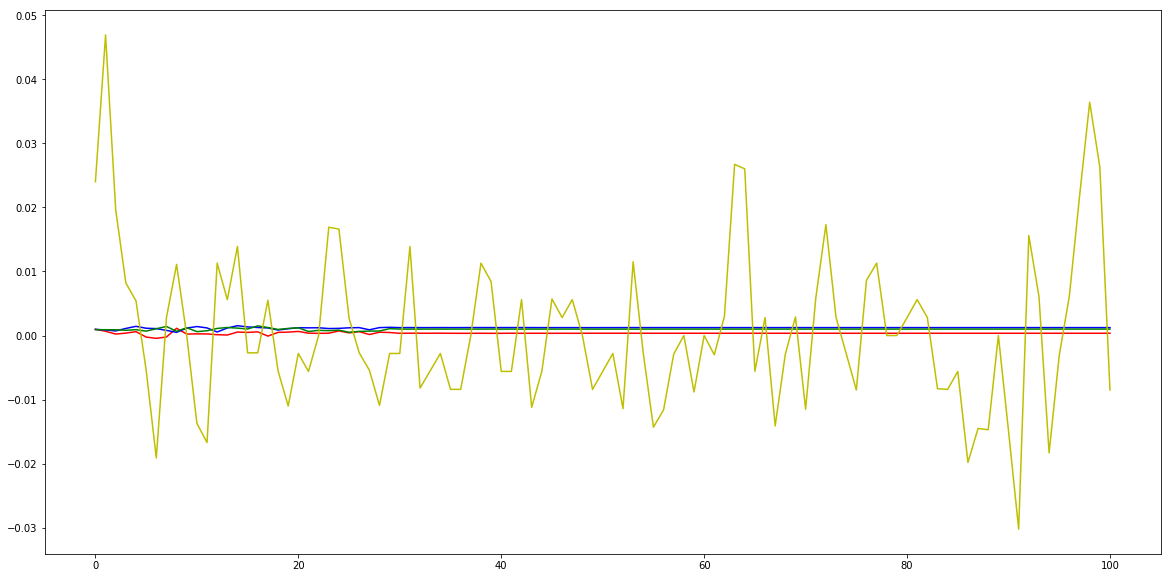

DTAC


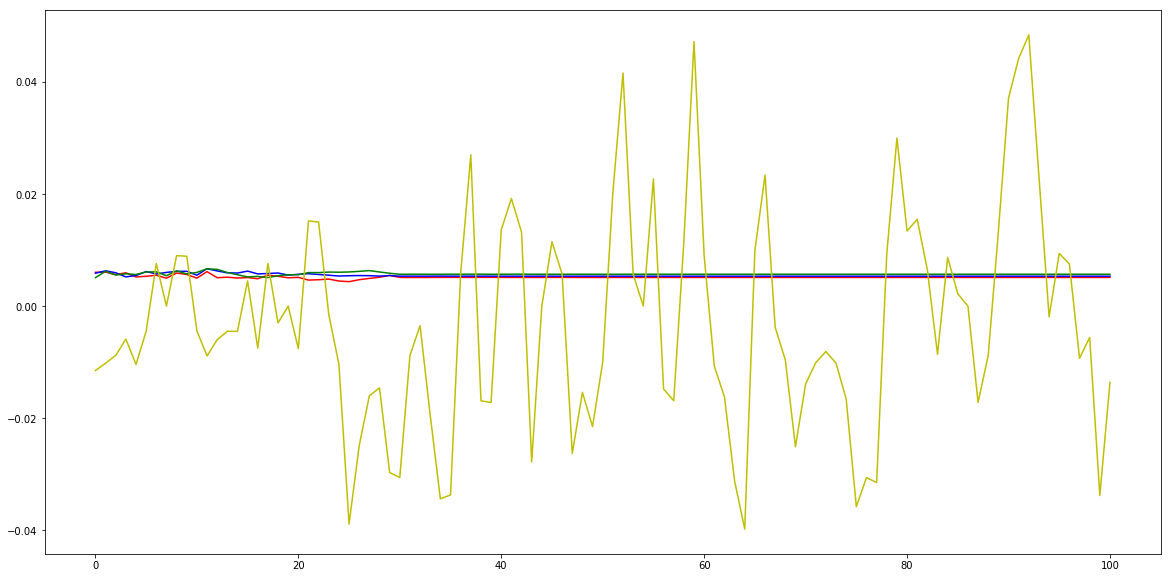

EGCO


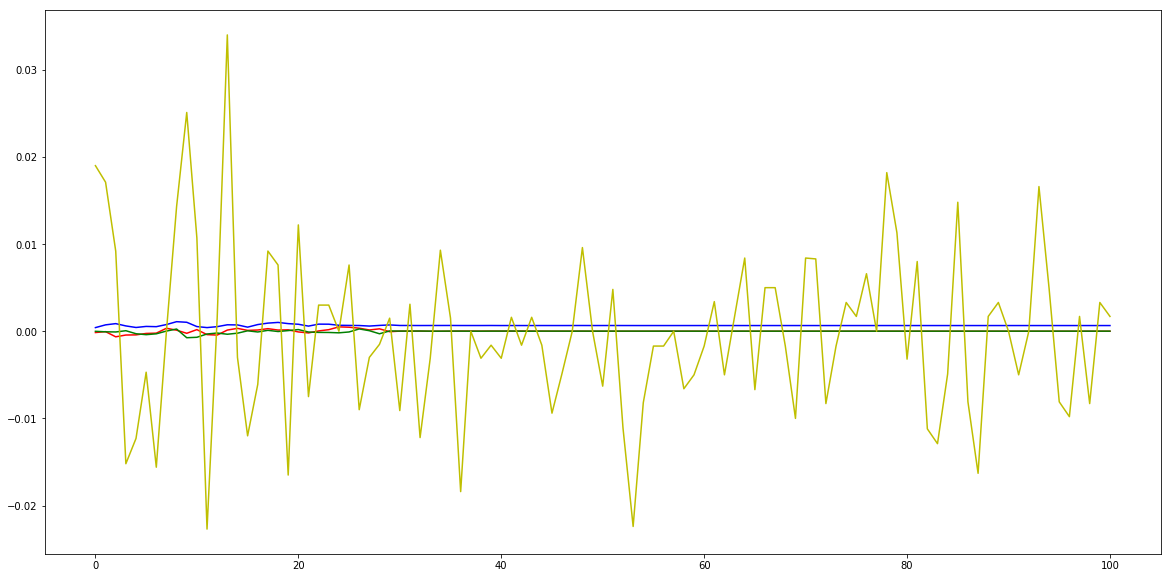

GLOBAL


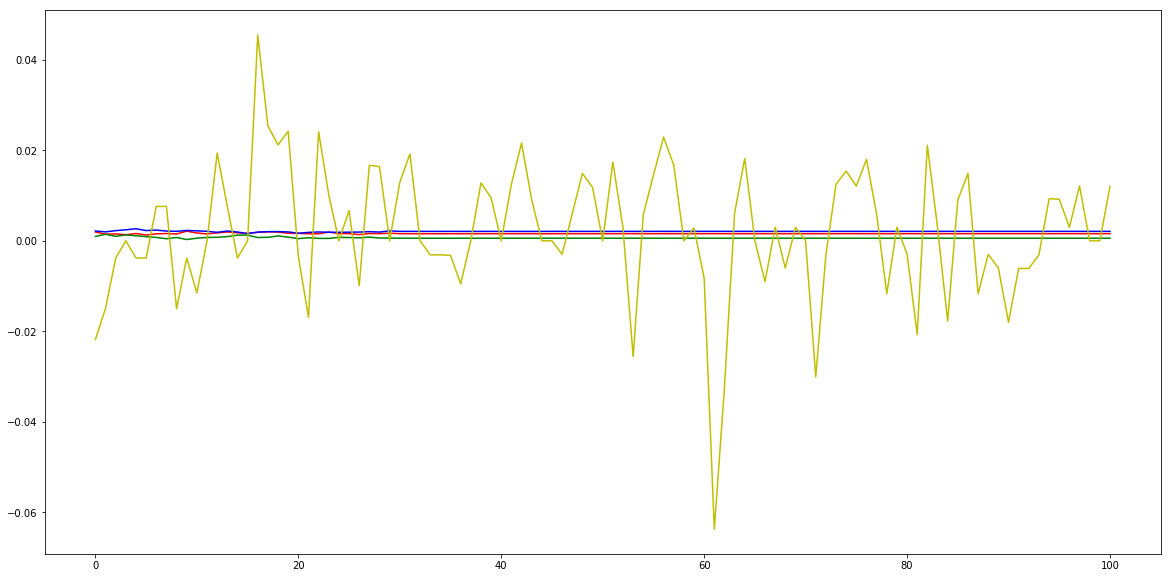

HMPRO


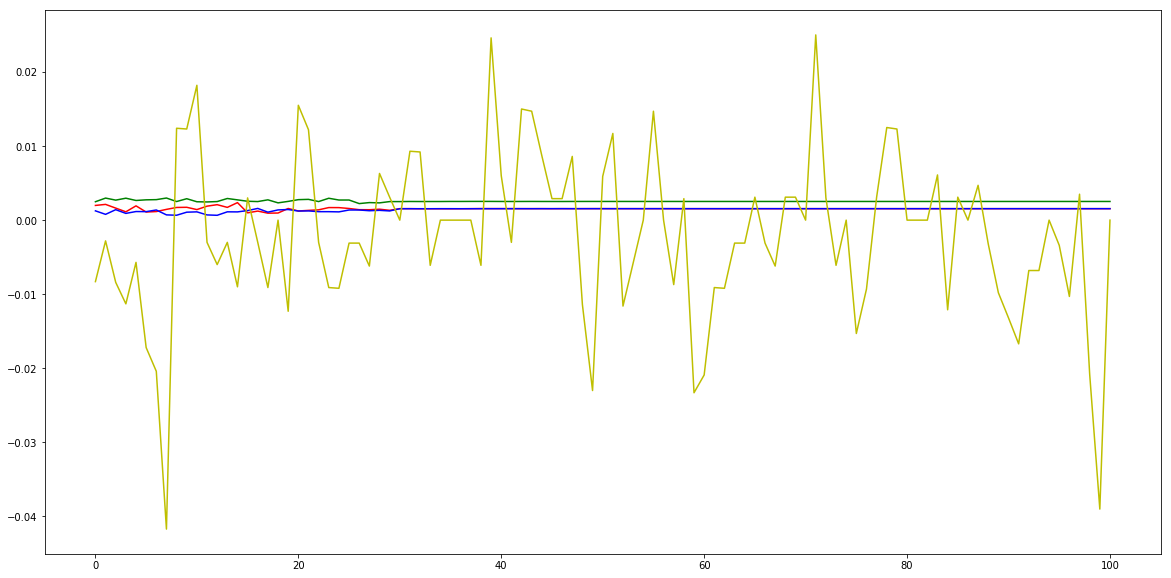

INTUCH


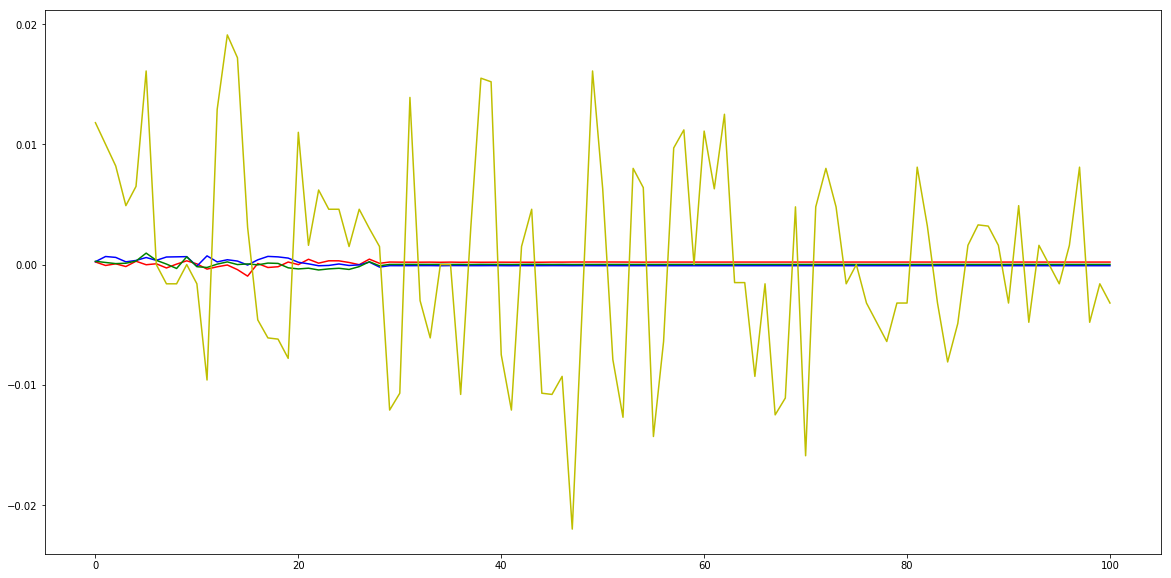

IRPC


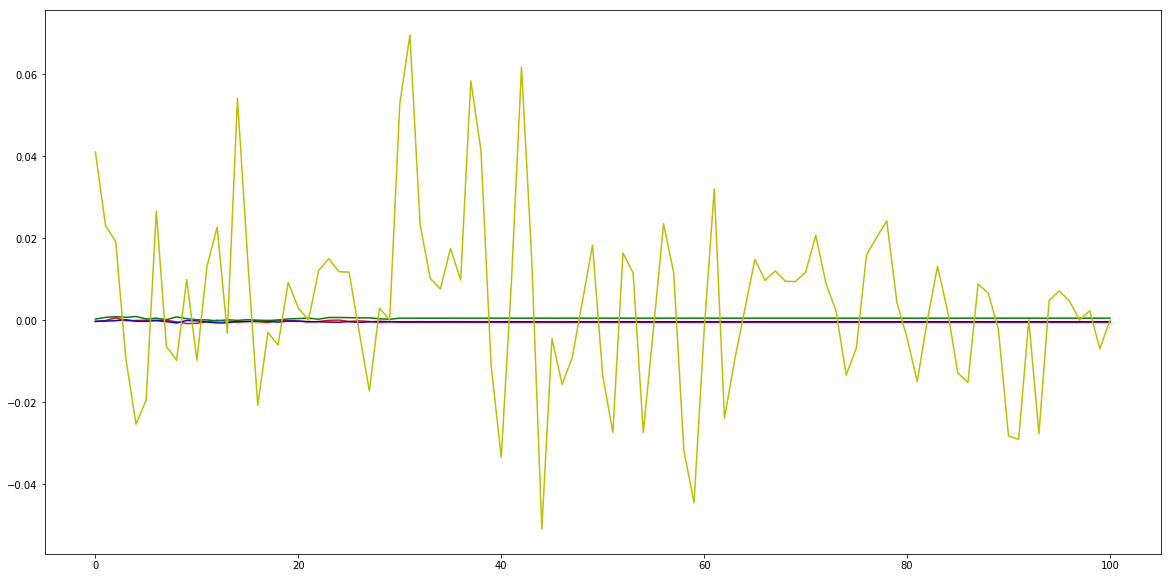

KBANK


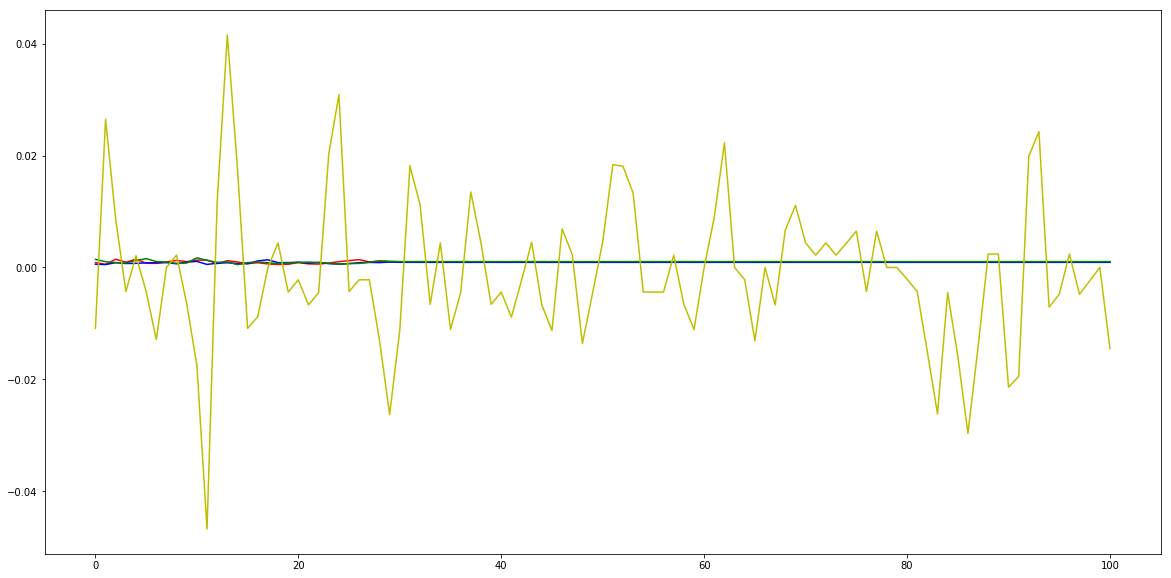

KCE


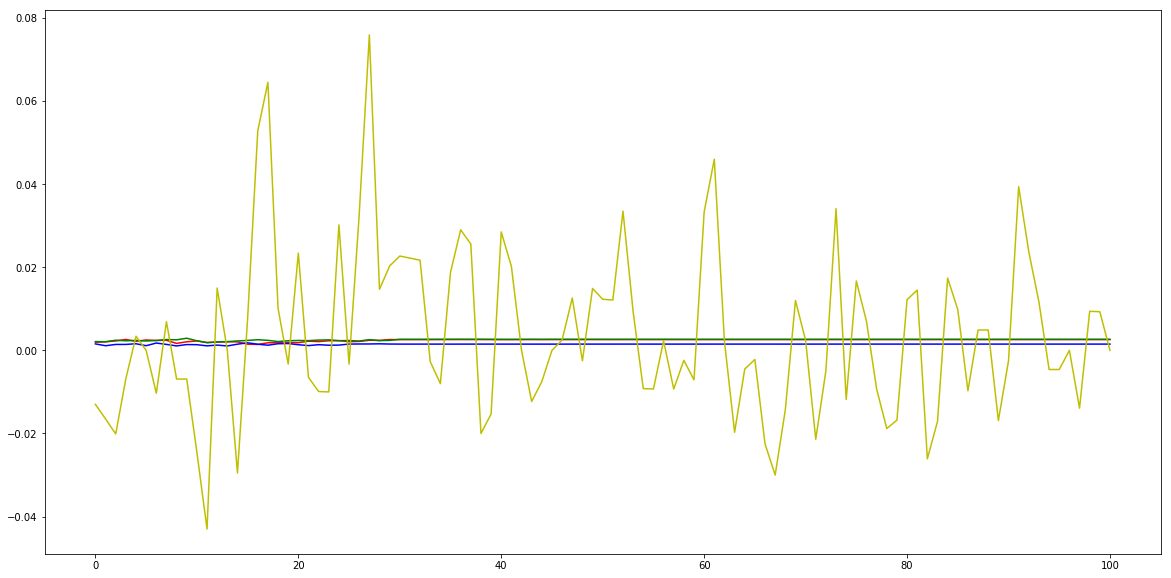

KKP


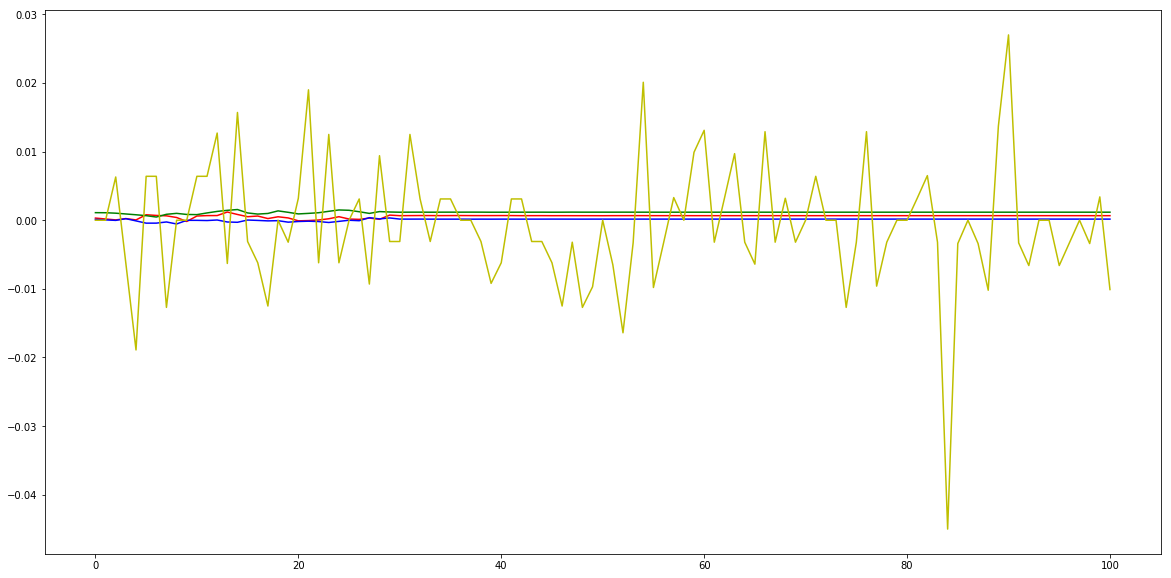

KTB


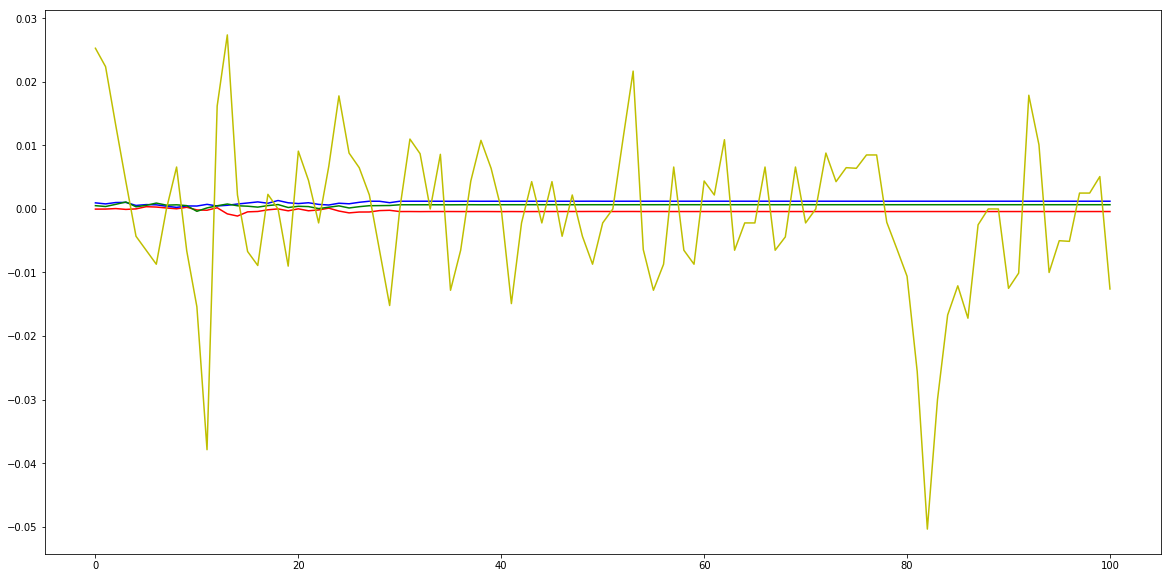

LH


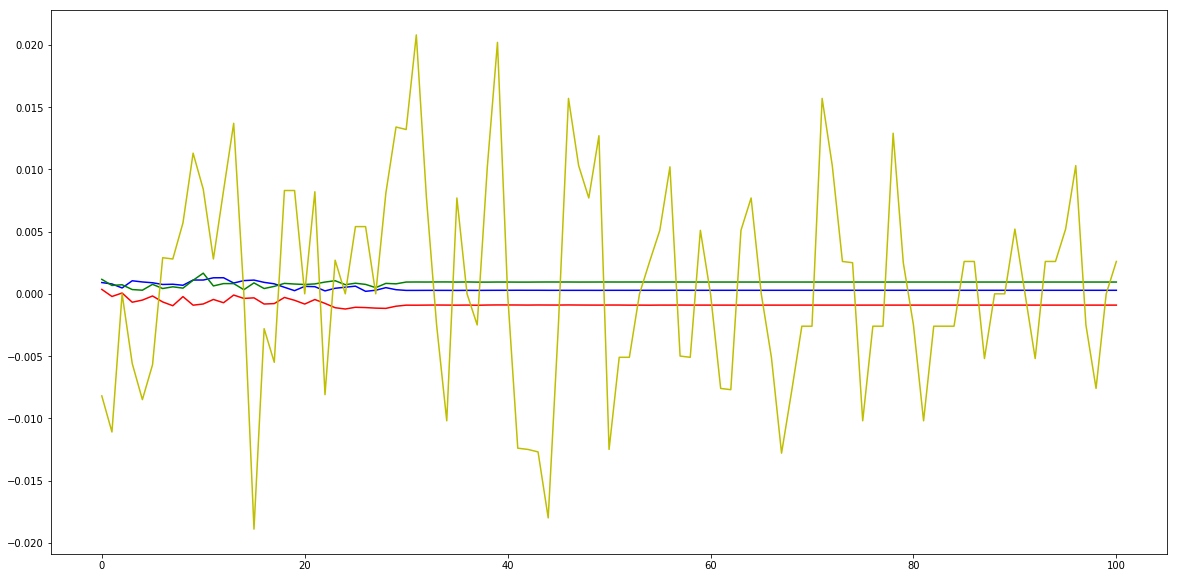

MINT


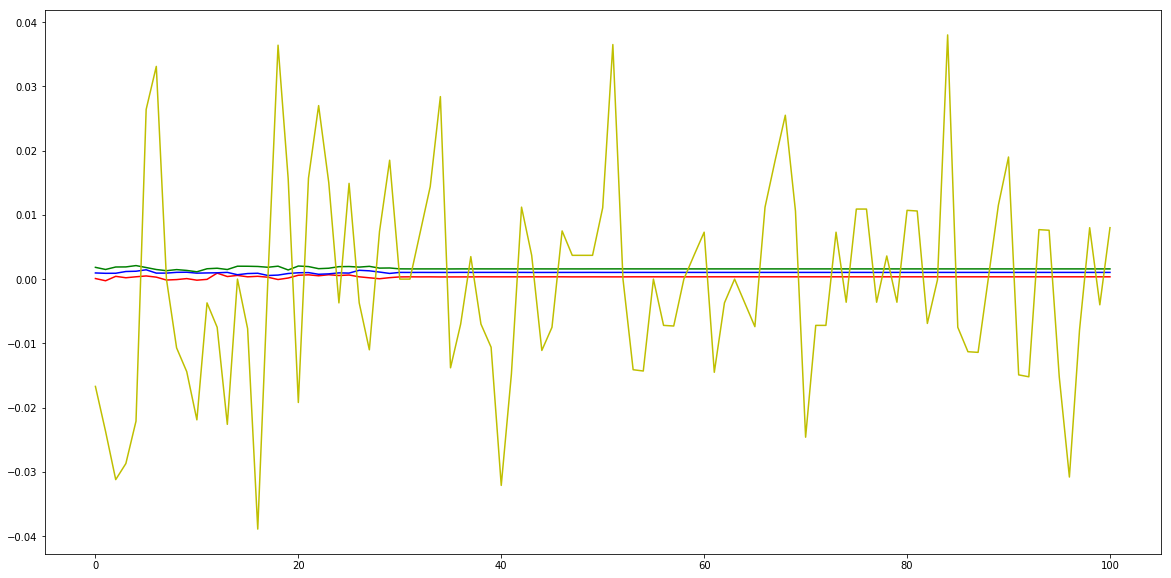

PTT


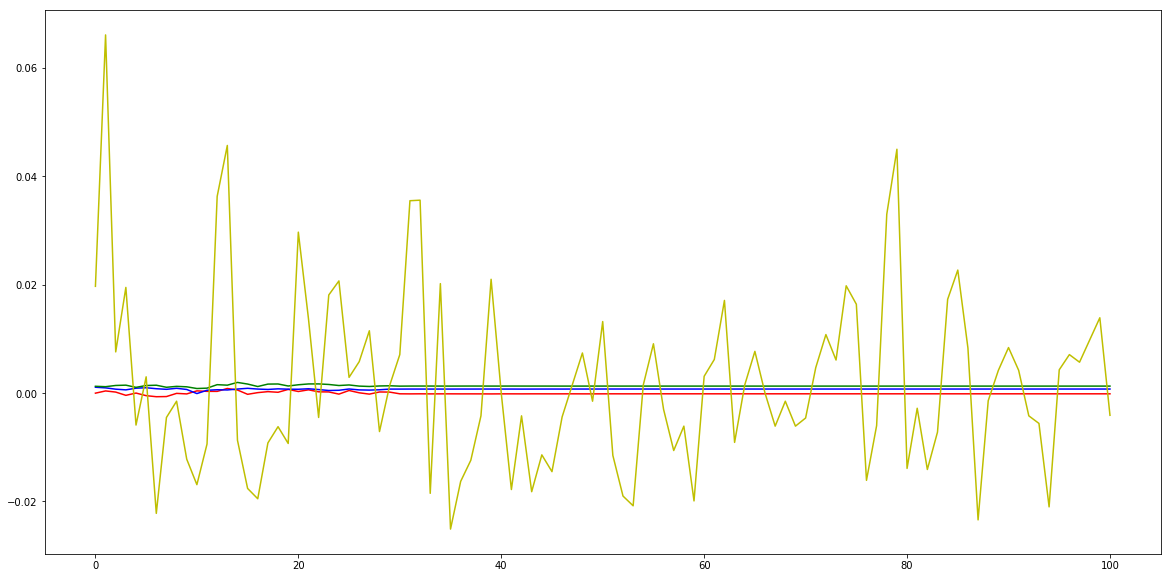

PTTEP


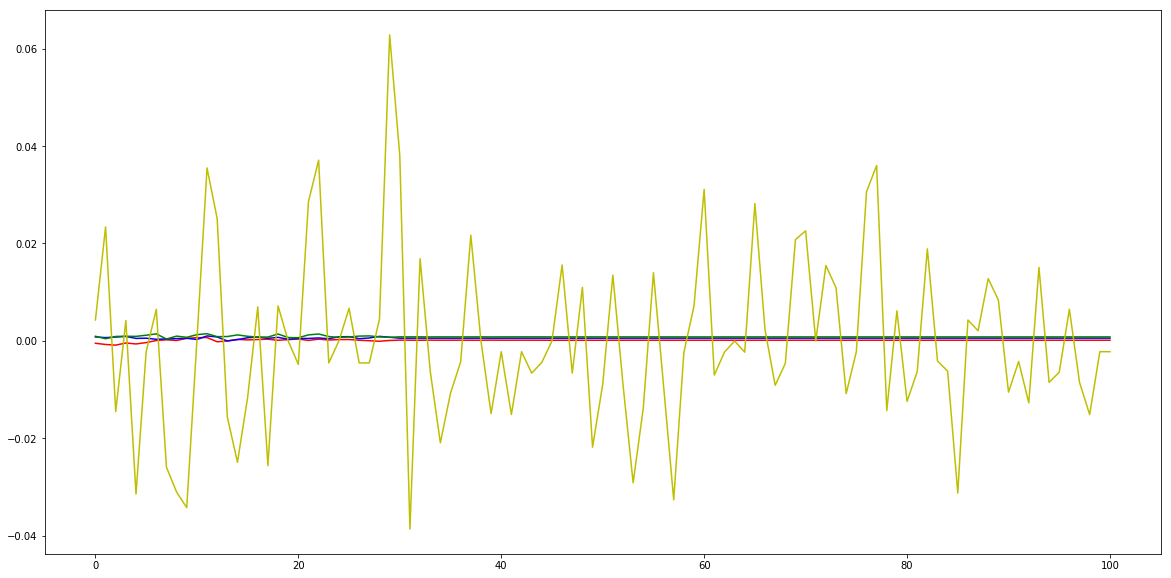

ROBINS


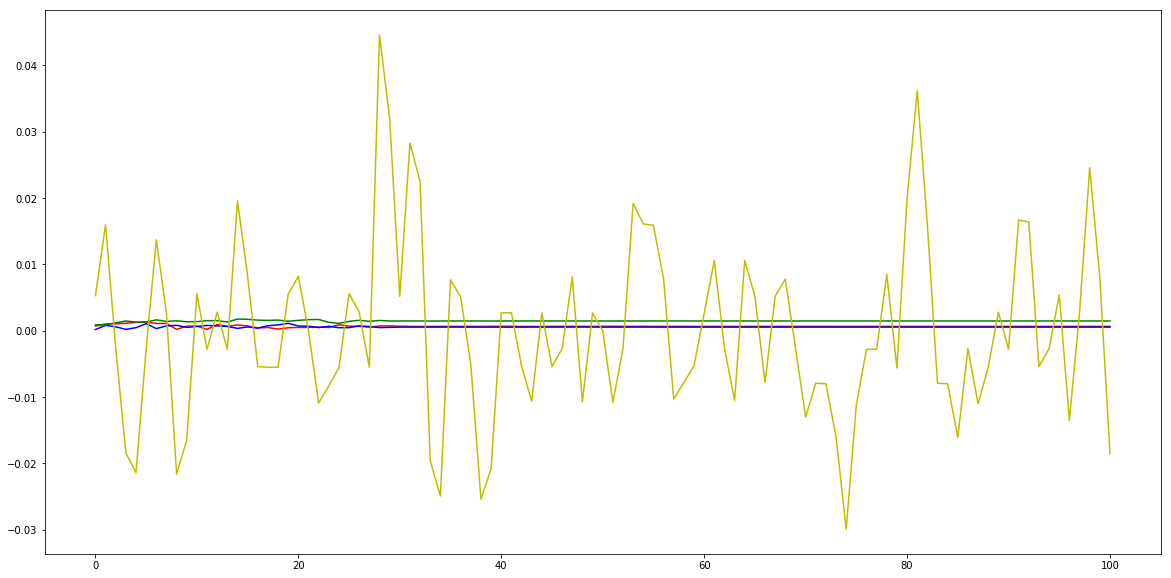

SCB


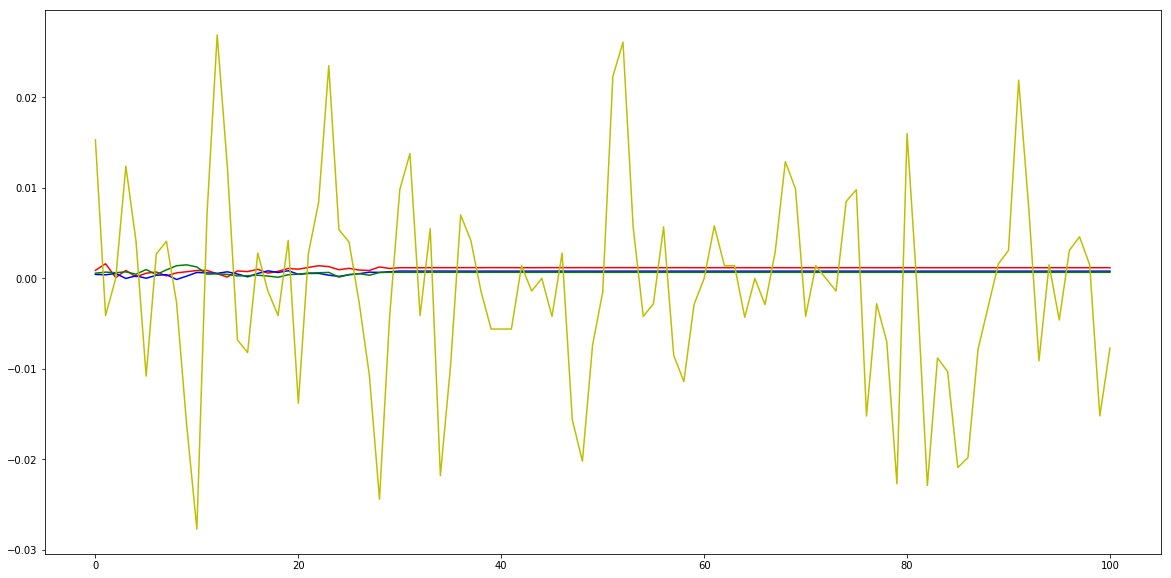

SCC


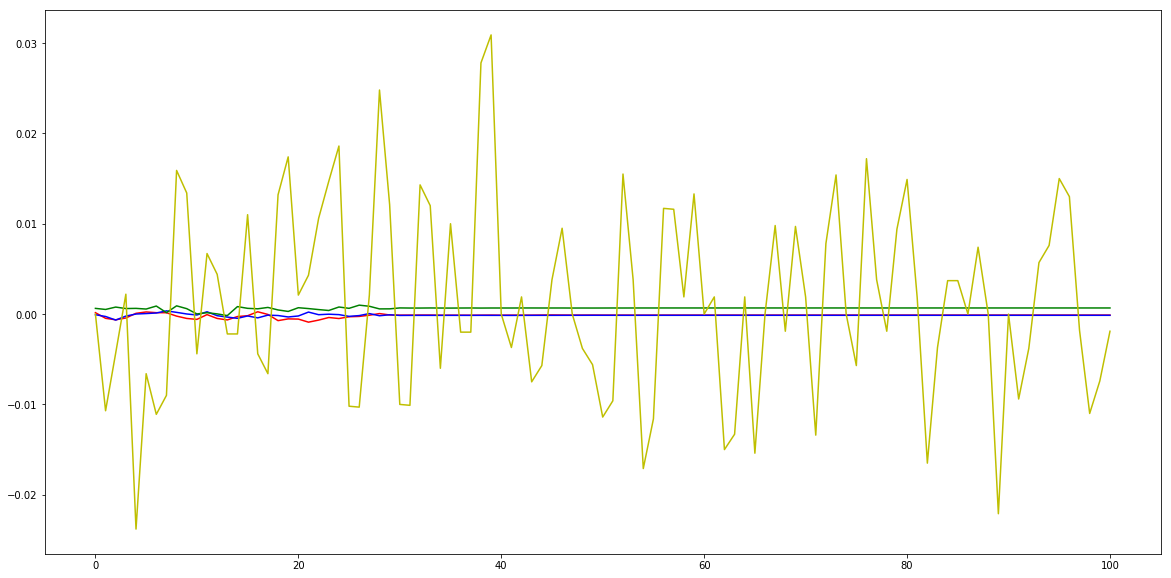

TCAP


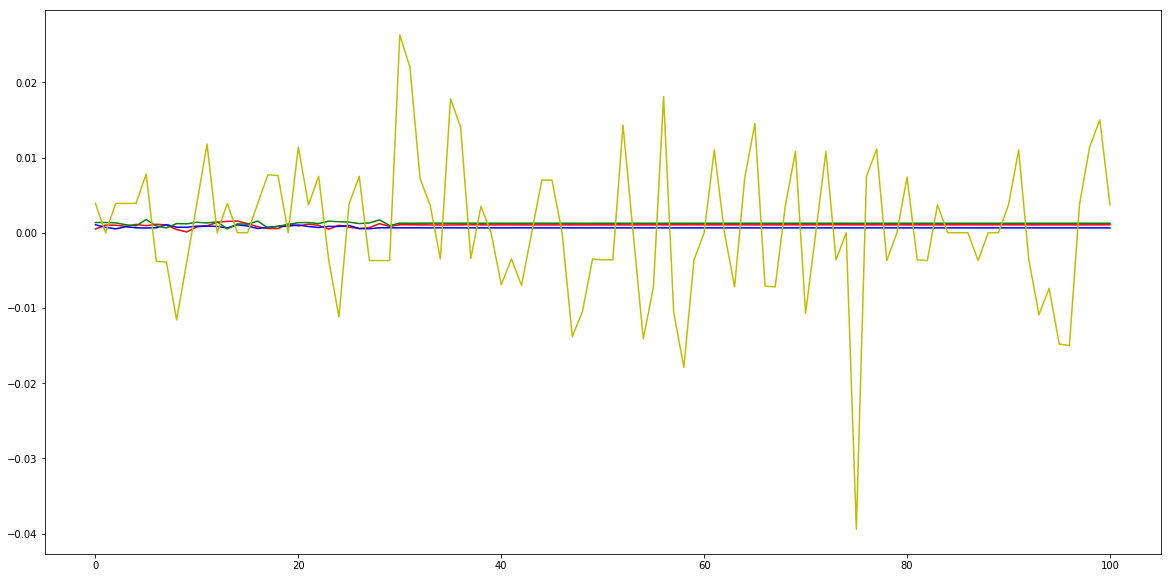

TISCO


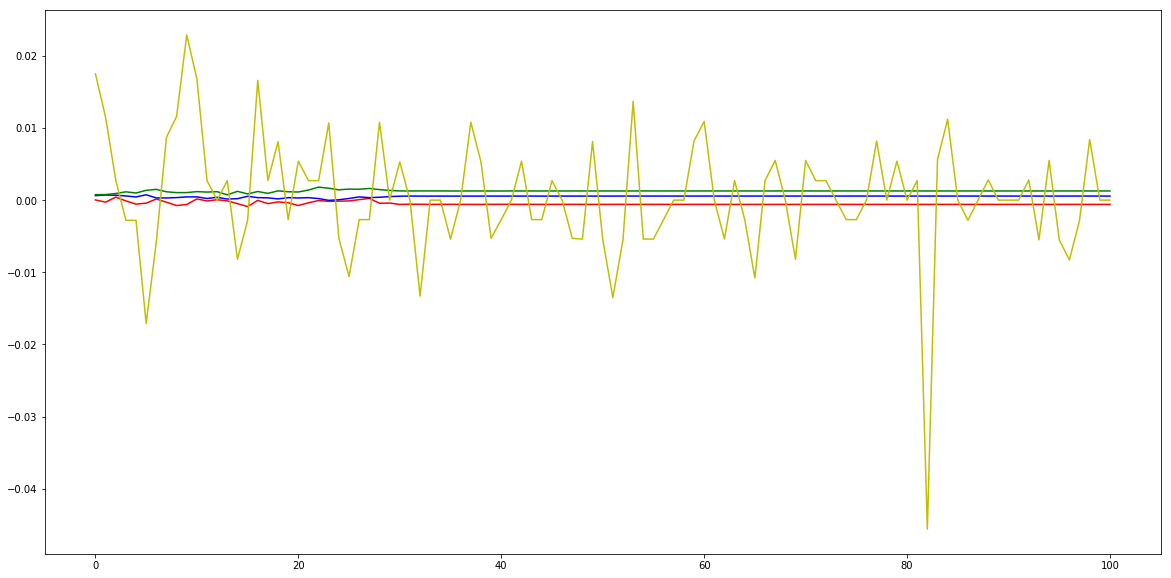

TMB


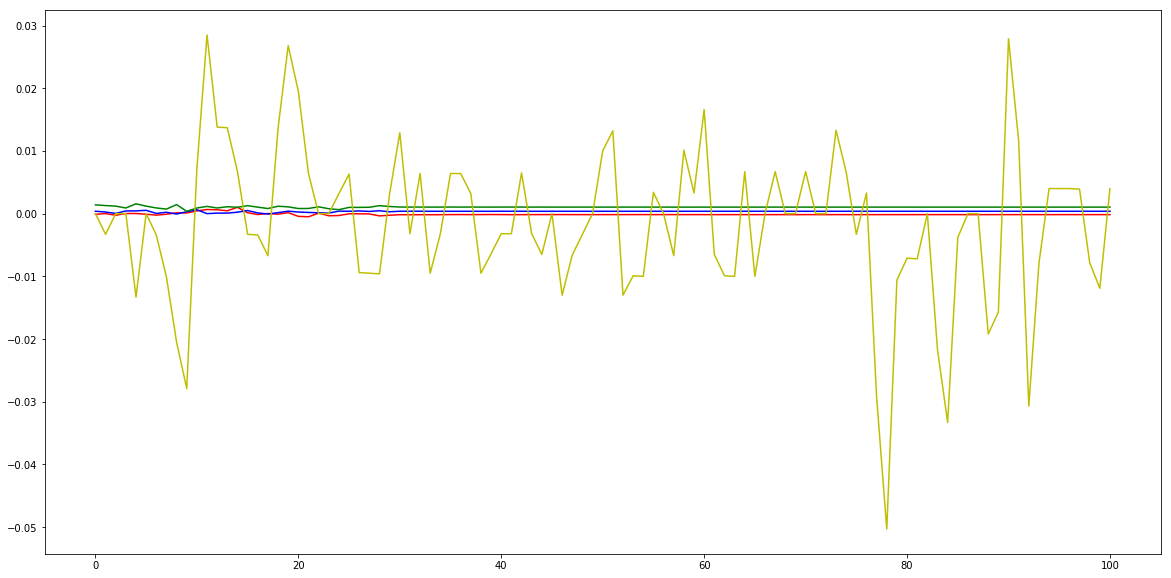

TOP


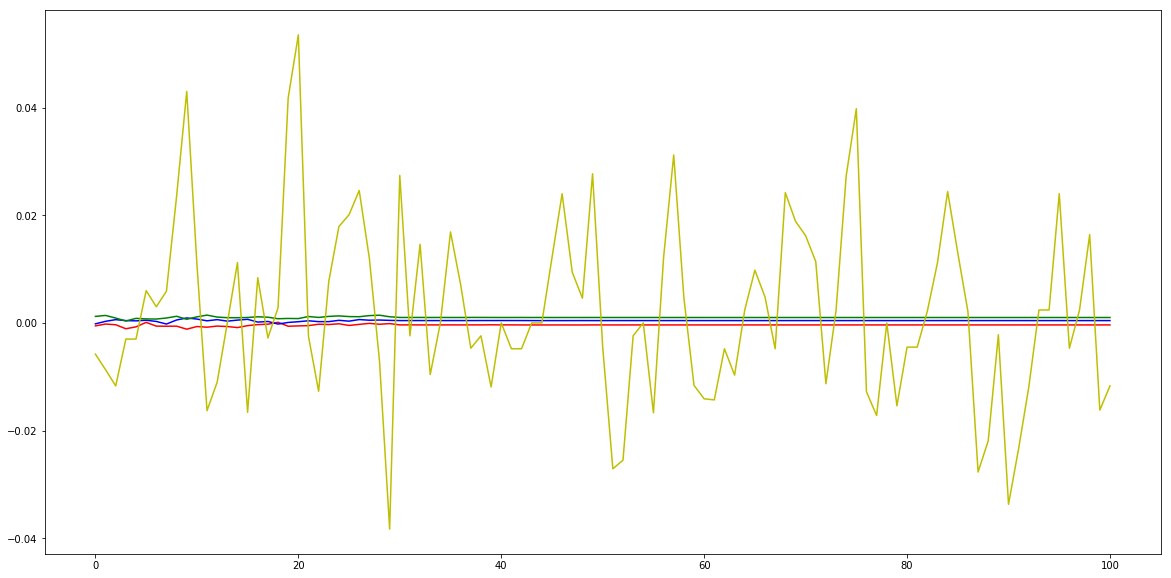

TRUE


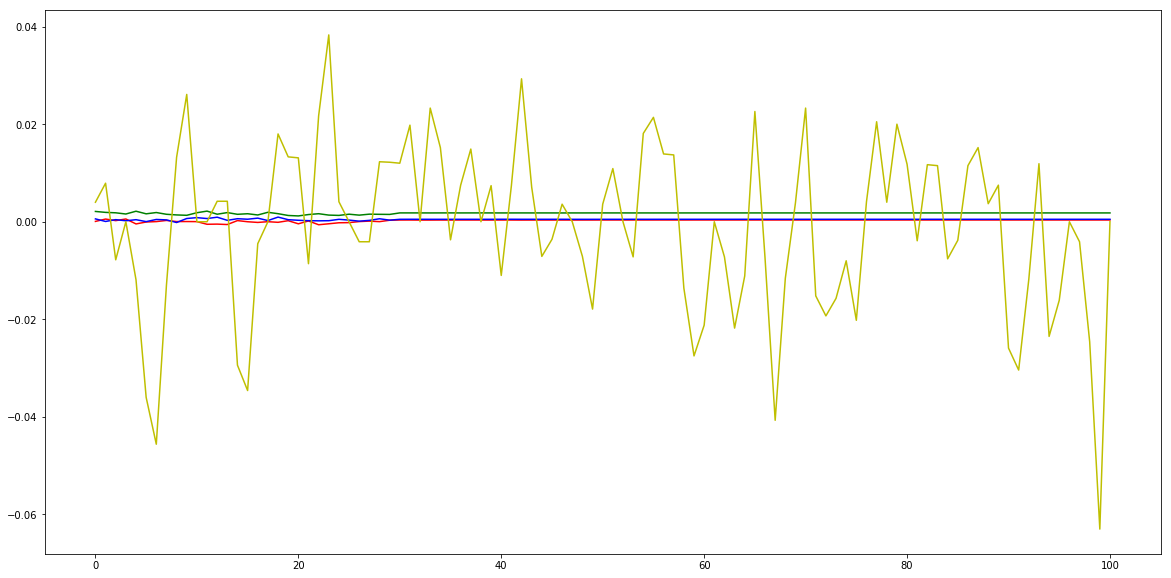

TU


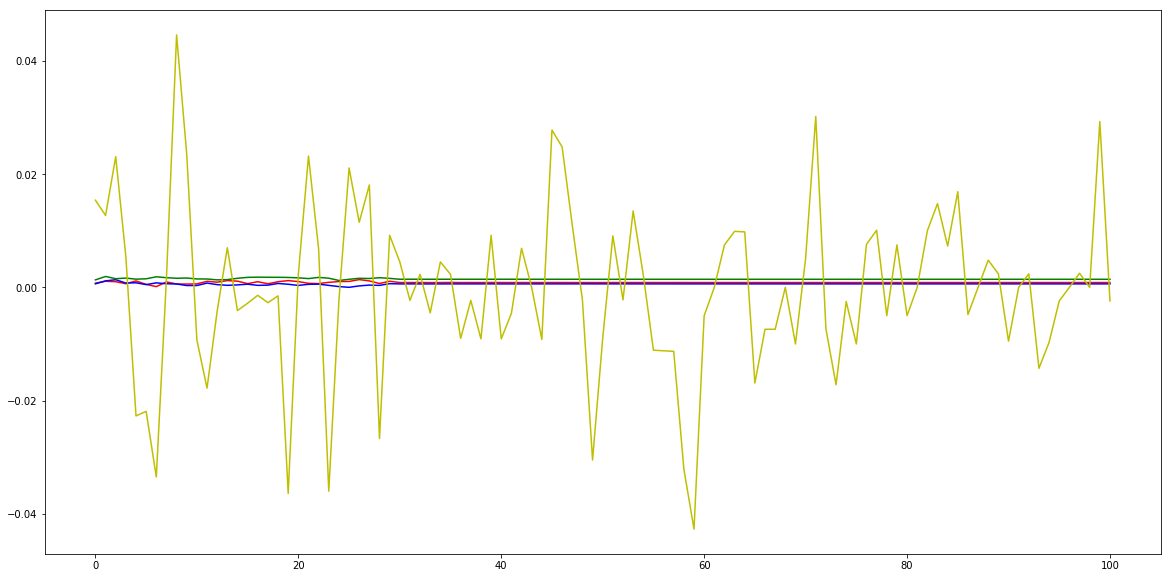

In [107]:
for i in range(len(SET50)):
    print(SET50[i])
    data1 = get_data_from_nparray(predicts[0], i)
    data2 = get_data_from_nparray(predicts[1], i)
    data3 = get_data_from_nparray(predicts[2], i)
    data4 = get_data_from_nparray(y_test, i)
    plot_graph(data1, data2, data3, data4)